## Tweets about Trump and Clinton

During the 2016 Presidential campaign, I collected a little over 270,000 tweets using the Twitter API and filtered for tweets that contained 'Trump', 'DonaldTrump', 'Hillary', 'Clinton', or 'HillaryClinton'.  The tweets were collected in July of 2016.

I'll preprocess these tweets to do some exploratory analysis, look at the most common co-occurring words, and perform sentiment analysis.

Twitter parameters: https://dev.twitter.com/streaming/overview/request-parameters#track

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import SVG 
import json
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
import string
from collections import Counter
import operator
import sqlalchemy
import sqlite3 as sql
import pickle
import warnings
warnings.filterwarnings("ignore")

In [2]:
def add_column_for_name(df, names_list, text_column):
    """
    Add column(s) that indicates whether name(s) is/are in text_column
    Args:
        df: pandas dataframe
        names_list: list of strings (names) 
        text_column: column containing text
    Returns:
        df with column of Booleans 
    """
    for name in names_list:
        mydf[name] = mydf['text'].apply(lambda tweet: word_in_text(name, tweet))
    return df


def remove_retweets(df, column, list_of_str):
    """
    Function to remove tweets that contain string in list_of_str
    """
    for string in list_of_str:
        df = df[df['text'].str.contains(string)==False]
    return df


def print_val_counts_for_True(df, list_of_cols):
    """
    Print number of Trues for columns in list_of_cols in dataframe df
    """
    for name in list_of_cols:
        print(name, df[name].value_counts()[True])

        
def word_in_text(word, text):
    """
    Function to make text lower case and return True if a term is present,
    False otherwise
    """
    word = word.lower()
    text = text.lower()
    match = re.search(word, text)
    if match:
        return True
    return False


def lower_text(list_text):
    """
    Make text lowercase
    """
    new_list_text = []
    for word in list_text:
        new_word = word.lower() 
        new_list_text.append(new_word)
    return new_list_text


def extract_link(text):
    """
    Extract links from tweets
    """
    regex = r'https?://[^\s<>"]+|www\.[^\s<>"]+'
    match = re.search(regex, text)
    if match:
        return match.group()
    return ''

# Functions for tokenizing and preprocessing

def tokenize(s):
    return tokens_re.findall(s)


def preprocess(s, lowercase = False):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens


def tweet_tokenize(text):
    """
    Tokenize text
    """
    tweet_tokens = preprocess(text, lowercase = False)
    return tweet_tokens


def itertools_flatten(list_of_list):
    """
    Flatten out list of lists
    """
    from itertools import chain
    return list(chain(*list_of_list))


def most_frequent(terms_all, names_list):
    """
    Returns most frequent terms, aside from stop words. terms_all is a list with all the terms
    """
    count_all = Counter()
    full_stop = stop + names_list
    interesting_terms = [term for term in terms_all if term not in full_stop]
    
    # Update the counter
    count_all.update(interesting_terms)
    return count_all.most_common(20)

def make_col_lowercase(df, list_of_cols):
    """
    Function to get lowercase of columns in list_of_cols
    Args:
        df: pandas dataframe
        list_of_cols: list of column names (string)
    """
    for string in list_of_cols:
        df['lower_'+ string] = df[string].apply(lambda tweet: lower_text(tweet))
    return df

In [3]:
# Data is stored in an sqlite database. Reading sqlite query into a dataframe:
conn = sql.connect('tweets.db')
mydf = pd.read_sql_query('SELECT lang, text FROM lang_text', conn)
conn.close()

In [4]:
mydf.count()

lang    278713
text    278713
dtype: int64

In [5]:
mydf['text'].describe()

count     278713
unique    132656
top             
freq       12012
Name: text, dtype: object

#### Adding columns that show whether the tweet contains a name of interest

I decided to add columns of Booleans that indicated whether a name was in the tweet or not.

I'm also interested in weeding out tweets that might be about Bill Clinton.  
Of course, while doing this I might be taking out tweets that are about the other kind of bill (legislative), but I'm going to assume that's a negligible number.

In [8]:
# Add columns for names of interest
names_list = ['trump','hillary','clinton','donaldtrump','hillaryclinton','bill']
add_column_for_name(mydf, names_list ,'text')

# Count number of Trues for columns in list_of_cols
list_of_cols = ['trump', 'donaldtrump', 'hillary', 'clinton', 'hillaryclinton']
print_val_counts_for_True(mydf, list_of_cols)

trump 127268
donaldtrump 15999
hillary 94226
clinton 82198
hillaryclinton 23025


#### Some cleanup: removing retweets

In [9]:
# Return df with duplicates removed. 
unique_tweets = mydf.drop_duplicates(inplace=False, subset='text')

len(unique_tweets)

132656

In [10]:
# Remove retweets
list_of_str = ['RT', 'rt', ' RT ']
originals = remove_retweets(unique_tweets, 'text', list_of_str)

originals = originals.reset_index(drop = True)
originals.head()

,lang,text,trump,hillary,clinton,donaldtrump,hillaryclinton
0,en,PROTEST WITH YOUR VOTE ITs TRUMP OR NEVER THE ...,True,False,False,False,False
1,pt,@lanadynamite ata mas trump não,True,False,False,False,False
2,pt,Republicanos entram com pedido formal para nov...,False,True,False,False,False
3,en,@CassandraRules @Iteration23 They should be fa...,True,False,False,False,False
4,en,"Donald Trump bought US$120,000 trip and dinner...",True,False,False,False,False


In [11]:
len(originals)

95923

#### Counting names

In [14]:
# Count number of Trues for columns in list_of_cols again, now with 'bill'
list_of_cols = ['trump', 'donaldtrump', 'hillary', 'clinton', 'hillaryclinton', 'bill']
print_val_counts_for_True(originals, list_of_cols)

trump 47493
donaldtrump 5241
hillary 31054
clinton 27664
hillaryclinton 7391
bill 1453


In [15]:
originals['just_trump'] = np.where((originals['trump']==True) & (originals['donaldtrump']== False), True, False)

originals['just_clinton'] = np.where((originals['hillary']==False) & (originals['clinton']== True) &
                                    (originals['hillaryclinton']==False) & (originals['trump']==False) &
                                    (originals['donaldtrump']==False), True, False)

originals['just_hillary'] = np.where((originals['hillary']==True) & (originals['clinton']== False) &
                                    (originals['hillaryclinton']==False) & (originals['trump']==False) &
                                    (originals['donaldtrump']==False), True, False)


originals['Any_Clinton'] = np.where((originals['trump']== False) & (originals['donaldtrump']==False), True, False)

originals['Any_Clinton_no_bill'] = np.where((originals['trump']== False) & (originals['donaldtrump']==False) & 
                                            (originals['bill']==False), True, False)

originals['Any_Trump'] = np.where((originals['hillary']==False) & (originals['clinton']== False) & 
                                  (originals['hillaryclinton']==False), True, False)

#### Extract links

In [16]:
originals['link'] = originals['text'].apply(extract_link)

In [17]:
# Getting value counts for names
list_of_cols = ['trump', 'donaldtrump', 'just_trump','hillary', 'clinton', 'hillaryclinton', 
                'just_hillary','just_clinton','Any_Trump','Any_Clinton','Any_Clinton_no_bill']

print_val_counts_for_True(originals, list_of_cols)

trump 47493
donaldtrump 5241
just_trump 42252
hillary 31054
clinton 27664
hillaryclinton 7391
just_hillary 10727
just_clinton 8965
Any_Trump 53400
Any_Clinton 48430
Any_Clinton_no_bill 47394


#### A plot for counts for names of interest

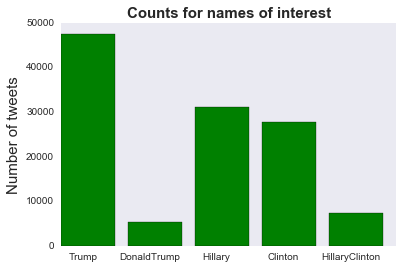

In [107]:
names = ['Trump', 'DonaldTrump', 'Hillary', 'Clinton', 'HillaryClinton']
tweets_by_name = [originals['trump'].value_counts()[True], originals['donaldtrump'].value_counts()[True], originals['hillary'].value_counts()[True], originals['clinton'].value_counts()[True], originals['hillaryclinton'].value_counts()[True]]
x_pos = list(range(len(names)))
width = 0.8
fig, ax = plt.subplots()
plt.bar(x_pos, tweets_by_name, width, alpha=1, color='g')
ax.set_ylabel('Number of tweets', fontsize=15)
ax.set_title('Counts for names of interest', fontsize=15, fontweight='bold')
ax.set_xticks([p + 0.4 * width for p in x_pos])
ax.set_xticklabels(names)
plt.grid()
plt.savefig('tweet_by_name_1', format='png')

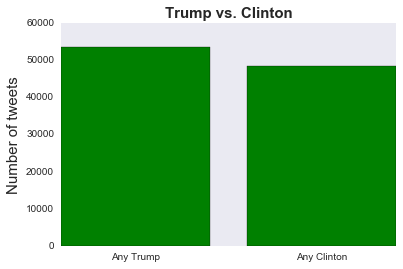

In [151]:
# Term frequencies for any Trump tweets and any Hillary or Clinton tweets, but not ones that have both
names = ['Any Trump', 'Any Clinton']
tweets_by_name = [originals['Any_Trump'].value_counts()[True], originals['Any_Clinton'].value_counts()[True]]
x_pos = list(range(len(names)))
width = 0.8
fig, ax = plt.subplots()
plt.bar(x_pos, tweets_by_name, width, alpha=1, color='g')
ax.set_ylabel('Number of tweets', fontsize=15)
ax.set_title('Trump vs. Clinton', fontsize=15, fontweight='bold')
ax.set_xticks([p + 0.5 * width for p in x_pos])
ax.set_xticklabels(names)
plt.grid()
plt.savefig('tweet_by_name_1', format='png')

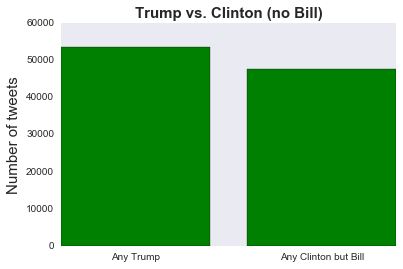

In [110]:
# Term frequencies for any Trump tweets and any Hillary or Clinton tweets, except the ones that contain 'Bill'
names = ['Any Trump', 'Any Clinton but Bill']
tweets_by_name = [originals['Any_Trump'].value_counts()[True], originals['Any_Clinton_no_bill'].value_counts()[True]]
x_pos = list(range(len(names)))
width = 0.8
fig, ax = plt.subplots()
plt.bar(x_pos, tweets_by_name, width, alpha=1, color='g')
ax.set_ylabel('Number of tweets', fontsize=15)
ax.set_title('Trump vs. Clinton (no Bill)', fontsize=15, fontweight='bold')
ax.set_xticks([p + 0.5 * width for p in x_pos])
ax.set_xticklabels(names)
plt.grid()
plt.savefig('tweet_by_name_1', format='png')

#### Languages

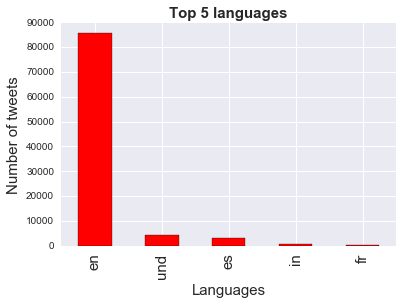

In [111]:
# Tweets by language
tweets_by_lang = originals['lang'].value_counts() #get the counts for the lang column
fig, ax = plt.subplots()
ax.tick_params(axis = 'x', labelsize=15)
ax.tick_params(axis = 'y', labelsize=10)
ax.set_xlabel('Languages', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 5 languages', fontsize=15, fontweight='bold')
tweets_by_lang[:5].plot(ax=ax, kind='bar', color='red')

#### Pre-processing tweets

In [114]:
# For pre-processing emoticons, @-mentions, hash-tags, URLs

emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]

# re.compile compiles a regex pattern into a regex object that can be used for match or search

tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)

# Add column of tokenized tweets
originals['tweet_tokens'] = originals['text'].apply(lambda tweet: tweet_tokenize(tweet))

#### Adding columns for tokens

In [115]:
originals['tweet_tokens'].head()

0    [PROTEST, WITH, YOUR, VOTE, ITs, TRUMP, OR, NE...
1                [@lanadynamite, ata, mas, trump, não]
2    [Republicanos, entram, com, pedido, formal, pa...
3    [@CassandraRules, @Iteration23, They, should, ...
4    [Donald, Trump, bought, US, $, 120,000, trip, ...
Name: tweet_tokens, dtype: object

In [116]:
# Adding a column for the tokens and also selecting for just the English ones
originals['just_trump_tokens'] = np.where((originals['lang']== 'en') & 
                                          (originals['Any_Trump'] ==True), originals['tweet_tokens'], '')

originals['just_clinton_tokens'] = np.where((originals['lang']== 'en') & 
                                            (originals['Any_Clinton_no_bill'] ==True), originals['tweet_tokens'], '')
originals.head()

,lang,text,trump,hillary,clinton,donaldtrump,hillaryclinton,bill,just_trump,just_clinton,just_hillary,Any_Clinton,Any_Clinton_no_bill,Any_Trump,tweet_tokens,just_trump_tokens,just_clinton_tokens
0,en,PROTEST WITH YOUR VOTE ITs TRUMP OR NEVER THE ...,True,False,False,False,False,False,True,False,False,False,False,True,"[PROTEST, WITH, YOUR, VOTE, ITs, TRUMP, OR, NE...","[PROTEST, WITH, YOUR, VOTE, ITs, TRUMP, OR, NE...",
1,pt,@lanadynamite ata mas trump não,True,False,False,False,False,False,True,False,False,False,False,True,"[@lanadynamite, ata, mas, trump, não]",,
2,pt,Republicanos entram com pedido formal para nov...,False,True,False,False,False,False,False,False,True,True,True,False,"[Republicanos, entram, com, pedido, formal, pa...",,
3,en,@CassandraRules @Iteration23 They should be fa...,True,False,False,False,False,False,True,False,False,False,False,True,"[@CassandraRules, @Iteration23, They, should, ...","[@CassandraRules, @Iteration23, They, should, ...",
4,en,"Donald Trump bought US$120,000 trip and dinner...",True,False,False,False,False,False,True,False,False,False,False,True,"[Donald, Trump, bought, US, $, 120,000, trip, ...","[Donald, Trump, bought, US, $, 120,000, trip, ...",


In [119]:
eng_trump_tokens = originals['just_trump_tokens'].values.tolist()
eng_clinton_tokens = originals['just_clinton_tokens'].values.tolist()

trump_list = itertools_flatten(eng_trump_tokens)
clinton_list = itertools_flatten(eng_clinton_tokens)

trump_list = [x.lower() for x in trump_list]
clinton_list = [x.lower() for x in clinton_list]

In [ ]:
list_of_cols = ['tweet_tokens', 'just_trump_tokens', 'just_clinton_tokens']
originals = make_col_lowercase(originals, list_of_cols)

#### Getting ready to count most frequent words by getting rid of stopwords, punctuation

In [137]:
# string.punctuation gives string of ASCI chars which are considered punctuation chars 
punctuation = list(string.punctuation)
more_punctuation = ["’", "‘"]

# A custom list of stopwords
more_stops = ["el", "don't", "it's", "get", "via", "rt", "de", "would", "make", "i'm", "2", 
              "he's", "one", "says","amp", "say", "us", "u"]

# The full stop list contains English stopwords, as well as my custom list of stopwords and punctuation to remove
stop = stopwords.words('english') + punctuation + more_punctuation + more_stops

trump_names_list = ['trump', 'donald', 'donaldtrump', '#trump', '@realdonaldtrump', "trump's"]
clinton_names_list= ['clinton', 'hillary', 'hillaryclinton', '@hillaryclinton']

#### Most frequent words associated with both candidates

In [142]:
print(most_frequent(clinton_list, clinton_names_list))

[('bernie', 6154), ('sanders', 5127), ('endorses', 1906), ('@berniesanders', 1710), ('like', 1663), ('president', 1355), ('lynch', 1323), ('vote', 1318), ('people', 1085), ('fbi', 1078), ('know', 1040), ('supporters', 1038), ('endorsement', 1005), ('democratic', 956), ('voting', 913), ('endorsed', 909), ('endorsing', 877), ('think', 800), ('email', 793), ('support', 746)]


In [143]:
most_frequent_trump =(most_frequent(trump_list, trump_names_list))
print(most_frequent_trump)

[('vp', 3138), ('like', 2219), ('pence', 1968), ('ginsburg', 1828), ('vote', 1724), ('gop', 1686), ('people', 1351), ('gingrich', 1317), ('bernie', 1316), ('news', 1227), ('ruth', 1202), ('president', 1167), ('bader', 1134), ('support', 1067), ('convention', 1064), ('think', 1045), ('republican', 1041), ('ryan', 1017), ('newt', 984), ('wall', 968)]


### Words that co-occurred most frequently with Clinton:

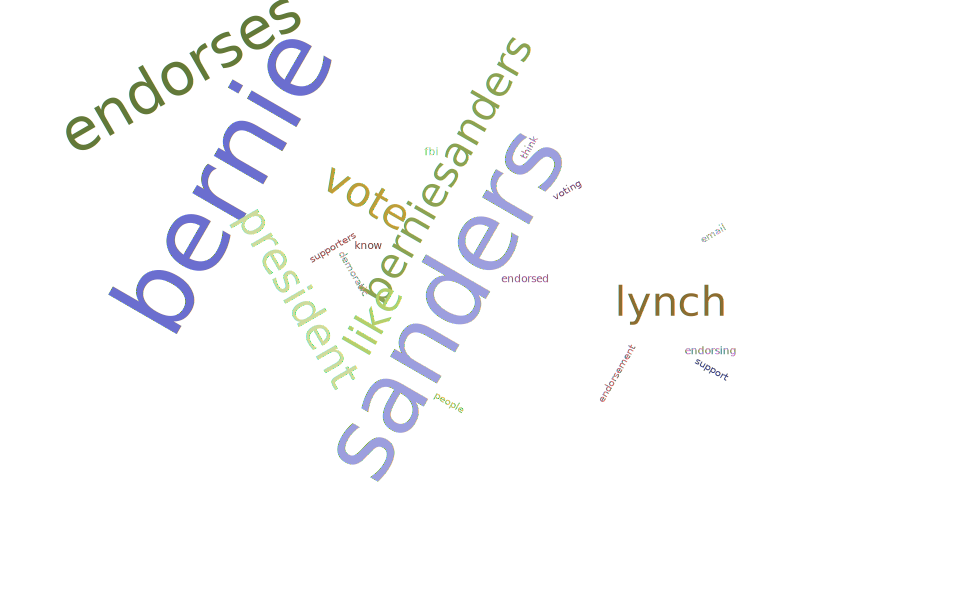

In [4]:
SVG(filename='clintonwordcloud.svg') 

Bernie Sanders had just endorsed Clinton around this time.

### Words that co-occurred most frequently with Trump:

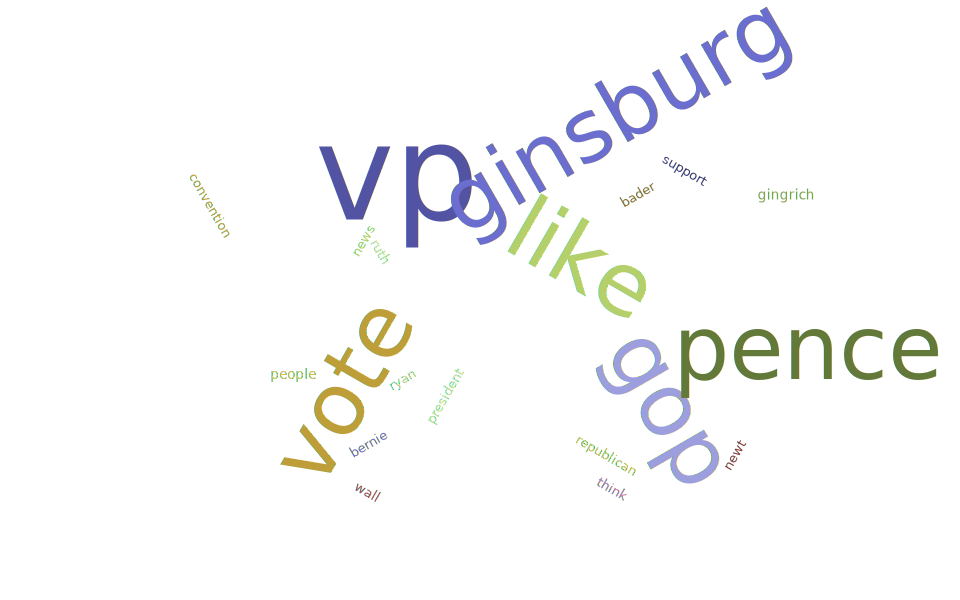

In [5]:
SVG(filename='trumpwordcloud.svg') 

During this period, Trump had recently declared Pence as his running mate. People were also talking about a spat between Trump and Ruth Bader Ginsburg.

For Part 2- sentiment analysis of the tweets.